In [26]:
!pip install -q transformers accelerate datasets evaluate scikit-learn torch torchvision torchaudio
import time, math, os, numpy as np, pandas as pd, torch
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.cluster import KMeans
from numpy.linalg import pinv
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

df = pd.read_csv('malicious_phish.csv')
df
df['type'].unique()
df['type'].value_counts()

# Standard label map for the Kaggle dataset
label_map = {'benign':0, 'defacement':1, 'phishing':2, 'malware':3}

# Clean & map labels
assert {'url','type'}.issubset(df.columns), "Expected columns: url, type"
df = df.dropna(subset=['url','type']).copy()
df['type'] = df['type'].astype(str).str.lower().map(label_map)
assert df['type'].notna().all(), "Found unmapped labels in df['type']; check label_map."

X_text = df['url'].astype(str).tolist()
y = df['type'].astype(int).to_numpy()

# Splits
train_idx, temp_idx, _, y_temp = train_test_split(
    np.arange(len(X_text)), y, test_size=0.30, stratify=y, random_state=42
)
val_idx, test_idx, _, _ = train_test_split(
    temp_idx, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

X_train_text = [X_text[i] for i in train_idx]
X_val_text   = [X_text[i] for i in val_idx]
X_test_text  = [X_text[i] for i in test_idx]

y_train = y[train_idx]
y_val   = y[val_idx]
y_test  = y[test_idx]

num_classes = len(label_map)
print("Split sizes:", len(X_train_text), len(X_val_text), len(X_test_text))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.6 MB/s eta 0:00:00
Device: cuda
Split sizes: 455833 97679 97679


In [27]:
from transformers import AutoTokenizer, AutoModel

MODEL_NAME = "distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(MODEL_NAME)
enc = AutoModel.from_pretrained(MODEL_NAME).to(device).eval()

@torch.inference_mode()
def embed_texts(texts, batch_size=64, max_len=128):
    out = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        t = tok(batch, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(device)
        h = enc(**t).last_hidden_state            # [B, L, H]
        mask = t.attention_mask.unsqueeze(-1)     # [B, L, 1]
        mean_pool = (h * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)
        out.append(mean_pool.cpu())
    return torch.vstack(out).numpy()

t0 = time.time()
X_train_emb = embed_texts(X_train_text)
X_val_emb   = embed_texts(X_val_text)
X_test_emb  = embed_texts(X_test_text)
print(f"Embedding time (minutes): {(time.time()-t0)/60:.2f}")

X_train_emb.shape, X_val_emb.shape, X_test_emb.shape


100%|██████████| 1527/1527 [01:05<00:00, 23.34it/s]

Embedding time (minutes): 7.33


((455833, 768), (97679, 768), (97679, 768))

In [28]:
def pairwise_sq_dists(A, B):
    A2 = np.sum(A*A, axis=1, keepdims=True)
    B2 = np.sum(B*B, axis=1, keepdims=True).T
    return A2 + B2 - 2 * A @ B.T  # [N, M]

def make_rb_features(X, centers, sigma=None):
    d2 = pairwise_sq_dists(X, centers)            # [N, M]
    if sigma is None:
        c_d2 = pairwise_sq_dists(centers, centers)
        mask = c_d2 > 0
        sigma = np.sqrt(np.mean(c_d2[mask])) if np.any(mask) else 1.0
        if not np.isfinite(sigma) or sigma == 0: sigma = 1.0
    Phi = np.exp(-d2 / (2 * sigma**2 + 1e-12))    # [N, M]
    Phi = np.hstack([Phi, np.ones((X.shape[0], 1))])  # bias -> [N, M+1]
    return Phi, sigma

def one_hot(y, num_classes):
    Y = np.zeros((y.shape[0], num_classes))
    Y[np.arange(y.shape[0]), y] = 1.0
    return Y

def fit_rbf_ridge_multiclass_weighted(
    X, y, centers, class_weights=None, l2=1e-2, sigma=None, num_classes=4
):
    Phi, sigma = make_rb_features(X, centers, sigma)
    Y = one_hot(y, num_classes)                      # [N, C]

    if class_weights is None:
        class_weights = {c: 1.0 for c in range(num_classes)}

    # Sample weights vector (N,)
    sample_weights = np.array([class_weights[yi] for yi in y], dtype=float)

    # We avoid forming a huge N x N diagonal matrix explicitly.
    # Compute Phi^T D Phi and Phi^T D Y with broadcasting:
    # (Phi^T * w) @ Phi  == Phi.T @ (w[:,None] * Phi)
    WPhi = sample_weights[:, None] * Phi             # [N, M+1]
    A = Phi.T @ WPhi                                 # (Phi^T D Phi)
    B = Phi.T @ (sample_weights[:, None] * Y)        # (Phi^T D Y)

    I = np.eye(Phi.shape[1])
    W = pinv(A + l2 * I) @ B                         # [M+1, C]
    return W, sigma

def predict_rbf_multiclass(X, centers, W, sigma):
    Phi, _ = make_rb_features(X, centers, sigma)
    Z = Phi @ W                                      # [N, C]
    Zexp = np.exp(Z - Z.max(axis=1, keepdims=True))
    P = Zexp / Zexp.sum(axis=1, keepdims=True)       # [N, C]
    yhat = np.argmax(P, axis=1)
    return yhat, P


In [29]:
# Inverse frequency weights (common heuristic)
counts = Counter(y_train)
total = sum(counts.values())
class_weights = {c: total/(len(counts)*counts[c]) for c in counts}
print("Class weights:", class_weights)


Class weights: {np.int64(0): 0.38027660241864436, np.int64(2): 1.729863988949102, np.int64(3): 5.006073185731857, np.int64(1): 1.68777029028436}


In [30]:
best = {"f1": -1, "K": None, "l2": None, "centers": None, "W": None, "sigma": None}
K_grid  = [32, 64, 96, 128]           # expand if you want
l2_grid = [1e-3, 3e-3, 1e-2, 3e-2]

t0 = time.time()
for K in K_grid:
    km_t = time.time()
    km = KMeans(n_clusters=K, random_state=42, n_init='auto').fit(X_train_emb)
    centers = km.cluster_centers_
    print(f"KMeans K={K} time (min): {(time.time()-km_t)/60:.2f}")
    for l2 in l2_grid:
        t1 = time.time()
        W, sigma = fit_rbf_ridge_multiclass_weighted(
            X_train_emb, y_train, centers,
            class_weights=class_weights, l2=l2, sigma=None, num_classes=num_classes
        )
        yv_hat, Pv = predict_rbf_multiclass(X_val_emb, centers, W, sigma)
        f1m = f1_score(y_val, yv_hat, average='weighted')
        print(f"  K={K}  l2={l2:.4g}  VAL weighted F1={f1m:.4f}  (min: {(time.time()-t1)/60:.2f})")
        if f1m > best["f1"]:
            best.update({"f1": f1m, "K": K, "l2": l2, "centers": centers, "W": W, "sigma": sigma})

print(f"\nBest VAL F1={best['f1']:.4f} with K={best['K']}  l2={best['l2']}")
print(f"Grid search time (minutes): {(time.time()-t0)/60:.2f}")


KMeans K=32 time (min): 0.84
  K=32  l2=0.001  VAL weighted F1=0.8494  (min: 0.03)
  K=32  l2=0.003  VAL weighted F1=0.8494  (min: 0.03)
  K=32  l2=0.01  VAL weighted F1=0.8494  (min: 0.03)
  K=32  l2=0.03  VAL weighted F1=0.8494  (min: 0.03)
KMeans K=64 time (min): 1.66
  K=64  l2=0.001  VAL weighted F1=0.8637  (min: 0.03)
  K=64  l2=0.003  VAL weighted F1=0.8637  (min: 0.03)
  K=64  l2=0.01  VAL weighted F1=0.8637  (min: 0.03)
  K=64  l2=0.03  VAL weighted F1=0.8636  (min: 0.03)
KMeans K=96 time (min): 2.26
  K=96  l2=0.001  VAL weighted F1=0.8739  (min: 0.04)
  K=96  l2=0.003  VAL weighted F1=0.8739  (min: 0.04)
  K=96  l2=0.01  VAL weighted F1=0.8739  (min: 0.04)
  K=96  l2=0.03  VAL weighted F1=0.8739  (min: 0.04)
KMeans K=128 time (min): 2.90
  K=128  l2=0.001  VAL weighted F1=0.8845  (min: 0.04)
  K=128  l2=0.003  VAL weighted F1=0.8845  (min: 0.04)
  K=128  l2=0.01  VAL weighted F1=0.8844  (min: 0.05)
  K=128  l2=0.03  VAL weighted F1=0.8843  (min: 0.04)

Best VAL F1=0.8845 wit

Transformer → RBFN (TEST)
              precision    recall  f1-score   support

      benign     0.9664    0.9031    0.9337     64216
  defacement     0.8425    0.9585    0.8968     14468
    phishing     0.6904    0.7024    0.6963     14117
     malware     0.6020    0.8452    0.7032      4878

    accuracy                         0.8794     97679
   macro avg     0.7753    0.8523    0.8075     97679
weighted avg     0.8900    0.8794    0.8824     97679

Confusion matrix:
 [[57993  1048  3931  1244]
 [  134 13867   224   243]
 [ 1794  1168  9916  1239]
 [   87   376   292  4123]]
Macro ROC-AUC: 0.9644698316466608


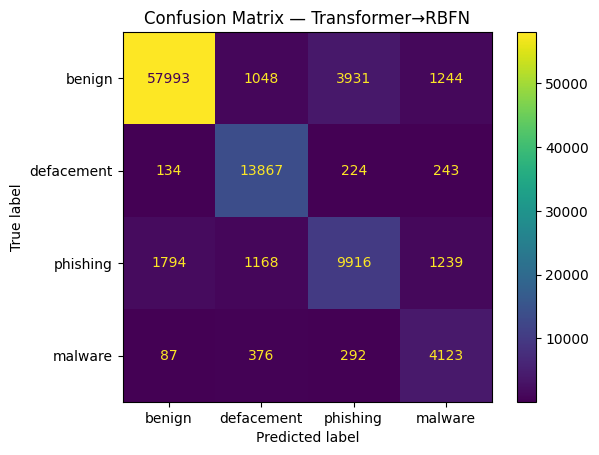

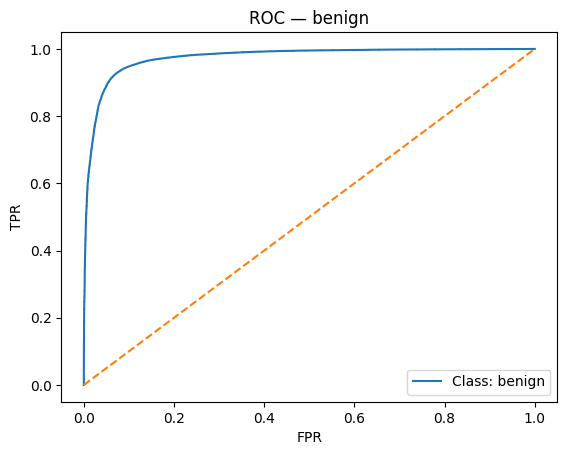

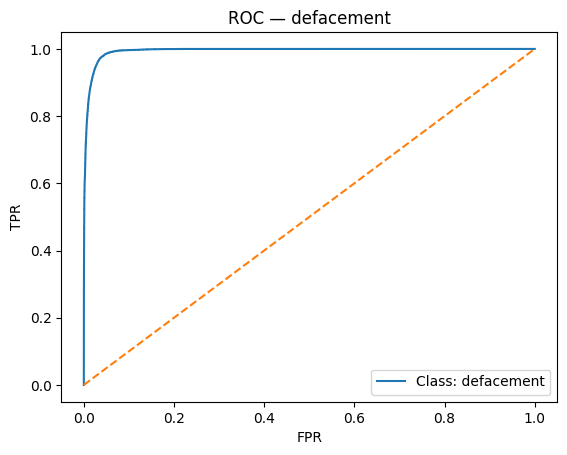

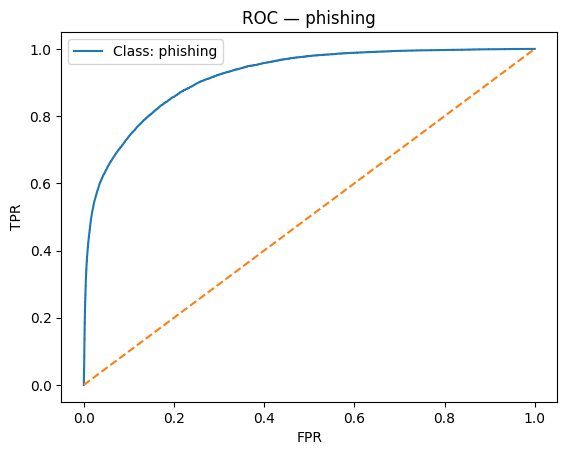

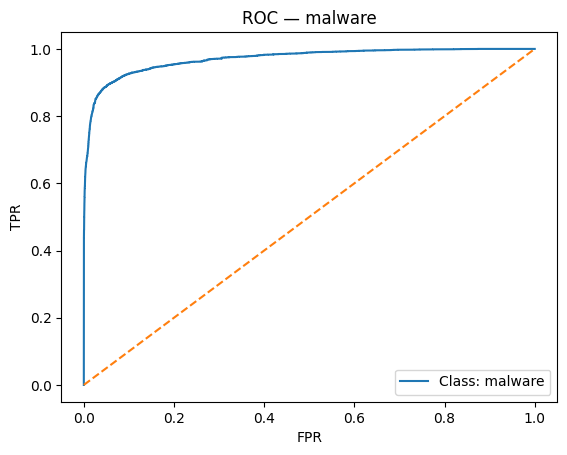

In [31]:
y_test_hat, Ptest = predict_rbf_multiclass(X_test_emb, best["centers"], best["W"], best["sigma"])

print("Transformer → RBFN (TEST)")
print(classification_report(y_test, y_test_hat, digits=4, target_names=list(label_map.keys())))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_hat))

# Macro ROC-AUC (one-vs-rest)
try:
    aucs = []
    for c in range(num_classes):
        y_true_c = (y_test == c).astype(int)
        aucs.append(roc_auc_score(y_true_c, Ptest[:, c]))
    print("Macro ROC-AUC:", np.mean(aucs))
except Exception as e:
    print("Macro ROC-AUC not available:", e)

# Optional plots
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve
ConfusionMatrixDisplay.from_predictions(y_test, y_test_hat, display_labels=list(label_map.keys()))
plt.title("Confusion Matrix — Transformer→RBFN")
plt.show()

# ROC for each class (optional)
for c, name in enumerate(label_map.keys()):
    y_true_c = (y_test == c).astype(int)
    fpr, tpr, _ = roc_curve(y_true_c, Ptest[:, c])
    plt.figure()
    plt.plot(fpr, tpr, label=f"Class: {name}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC — {name}"); plt.legend(); plt.show()


In [32]:
y_test_hat, Ptest = predict_rbf_multiclass(X_test_emb, best["centers"], best["W"], best["sigma"])
print("Transformer→RBFN (TEST):")
print(classification_report(y_test, y_test_hat, digits=4, target_names=list(label_map.keys())))
print("Confusion matrix:\n", confusion_matrix(y_test, y_test_hat))

# Macro ROC-AUC (one-vs-rest); works if each class present in test
try:
    # build one-vs-rest targets for macro AUC
    aucs = []
    for c in range(num_classes):
        y_true_c = (y_test == c).astype(int)
        aucs.append(roc_auc_score(y_true_c, Ptest[:, c]))
    print("Macro ROC-AUC:", np.mean(aucs))
except Exception as e:
    print("Macro ROC-AUC not available:", e)


Transformer→RBFN (TEST):
              precision    recall  f1-score   support

      benign     0.9664    0.9031    0.9337     64216
  defacement     0.8425    0.9585    0.8968     14468
    phishing     0.6904    0.7024    0.6963     14117
     malware     0.6020    0.8452    0.7032      4878

    accuracy                         0.8794     97679
   macro avg     0.7753    0.8523    0.8075     97679
weighted avg     0.8900    0.8794    0.8824     97679

Confusion matrix:
 [[57993  1048  3931  1244]
 [  134 13867   224   243]
 [ 1794  1168  9916  1239]
 [   87   376   292  4123]]
Macro ROC-AUC: 0.9644698316466608


In [34]:
def predict_url_hybrid(url: str):
    enc.eval()
    with torch.inference_mode():
        t = tok([url], padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        h = enc(**t).last_hidden_state
        mask = t.attention_mask.unsqueeze(-1)
        emb = ((h * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1)).cpu().numpy()
    yhat, P = predict_rbf_multiclass(emb, best["centers"], best["W"], best["sigma"])
    inv_map = {v: k for k, v in label_map.items()}  # invert to {idx: label}
    return inv_map[int(yhat[0])]   # return only the predicted type


# Quick check
for u in [
    "https://www.paypal.com/login",
    "http://br-icloud.com.br",
    "https://en.wikipedia.org/wiki/Main_Page"
]:
    print(f"URL: {u}")
    print(f"Type: {predict_url_hybrid(u)}\n")



URL: https://www.paypal.com/login
Type: defacement

URL: http://br-icloud.com.br
Type: defacement

URL: https://en.wikipedia.org/wiki/Main_Page
Type: benign

